In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import root_numpy as rtnp
import ROOT as rt
import sys, yaml, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = ' '*7+'Internal Simulation'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
dset = {}

dset['mu_0'] = DSetLoader('B0_MuNuDmst_PU0', loadSkim='all')
dset['muHQET_0'] = DSetLoader('B0_MuNuDmst_HQETcentral_PU0', loadSkim='all')

dset['mu_c0'] = DSetLoader('B0_MuNuDmst_PUc0', loadSkim='all')

In [7]:
dset['mu_c0'].data

{'High_corr':          index         q2    Est_mu   M2_miss    U_miss      mu_pt    mu_eta  \
 0            0   3.193787  1.985510 -0.032803 -0.003161  22.297549 -0.533417   
 1            1   1.481017  1.469344 -0.091270 -0.005405  12.496204 -0.910587   
 2            2   5.573213  1.914650 -0.165040 -0.008317  22.328305 -0.733139   
 3            3   7.706246  1.647060  1.311452  0.027547  22.392390 -1.069379   
 4            4   1.609278  1.540377  0.247459  0.010150  12.123881 -1.373417   
 5            5   4.382076  1.499270  1.335661  0.059720  17.104942 -0.097661   
 6            6   1.128328  2.131368  0.009043  0.004165  12.507719  0.171900   
 7            7   3.234901  1.448638  0.841704  0.042049  13.814281  0.875986   
 8            8   2.219093  1.944222  0.270601  0.043170  13.161973 -0.120454   
 9            9   3.085198  1.806408  0.526129  0.018667  36.334457  1.024271   
 10          10   5.307212  1.386182  1.669062  0.075864  15.218247  0.867113   
 11          11

# Preliminary study

In [8]:
# parCLN = 'RhoSq'
# parCLN_label = '#rho^{2}'

parCLN = 'eig1'
parCLN_label = '#lambda_{1}'

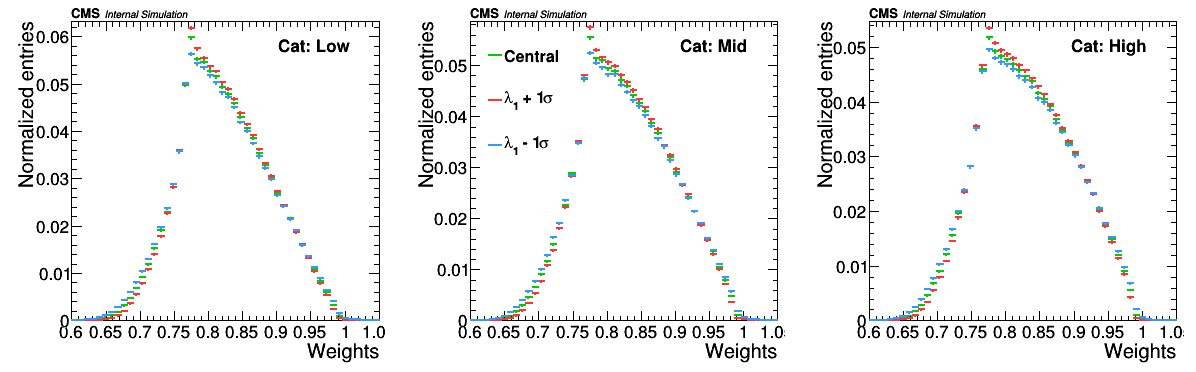

In [9]:
c = rt.TCanvas('c', 'c', 1200, 400)
c.Divide(3)
dnd = []
for ic, cat in enumerate(['Low', 'Mid', 'High']):
    a = dset['mu_c0'].data[cat+'_corr']
    h = create_TH1D(a['wh_CLNCentral'], 
                    axis_title=['Weights', 'Normalized entries'],
                    color=2,
                    binning=[50,0.6,1.05],
                    scale_histo='norm')
    h2 = create_TH1D(a['wh_CLN{}Up'.format(parCLN)], binning=h.binning,
                     color=1,
                     scale_histo='norm')
    h3 = create_TH1D(a['wh_CLN{}Down'.format(parCLN)], binning=h.binning,
                     color=0,
                     scale_histo='norm')
    
    pad = c.cd(ic+1)
    h.Draw()
    h2.Draw('same')
    h3.Draw('same')
    text = rt.TText(0.9, 0.9, 'Cat: '+cat)
    text.SetTextAlign(33)
    text.SetNDC()
    text.Draw()
    dnd.append([h, h2, h3, text])
    CMS_lumi.CMS_lumi(pad, -1, 0)

c.cd(2)
l = rt.TLegend(0.2, 0.55, 0.4, 0.92)
l.SetBorderSize(0)
l.AddEntry(h, 'Central', 'l')
l.AddEntry(h2, parCLN_label + ' + 1#sigma', 'l')
l.AddEntry(h3, parCLN_label + ' - 1#sigma', 'l')
l.Draw()
c.Draw()

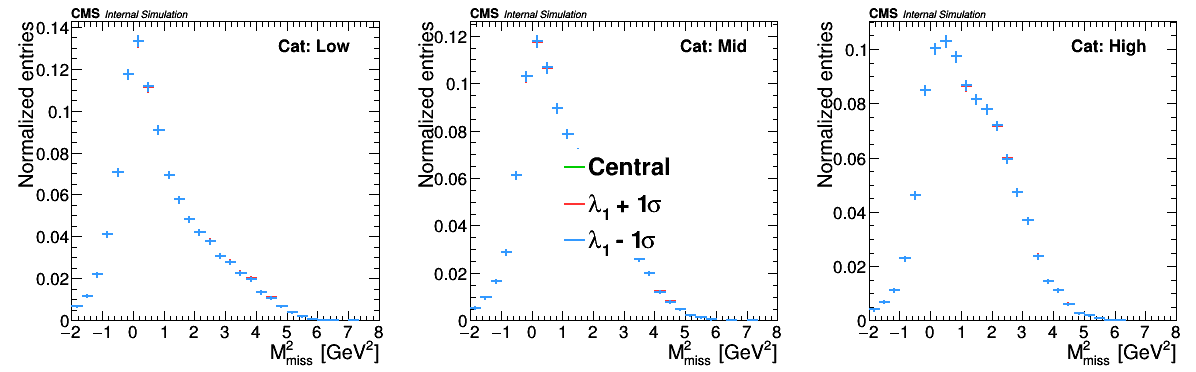

In [21]:
c = rt.TCanvas('c', 'c', 1200, 400)
c.Divide(3)
dnd = []

ivar = 1
var = ['q2', 'M2_miss'][ivar]
varName = ['q^{2}_{true}', 'M^{2}_{miss}'][ivar]
binning = [[30,-1,12.], [30,-2,8]][ivar]

for ic, cat in enumerate(['Low', 'Mid', 'High']):
    a = dset['mu_c0'].data[cat+'_corr']
    sel = a['MC_q2'] > 9.4
    
    h = create_TH1D(a[var][sel], weights=a['wh_CLNCentral'][sel], 
                    axis_title=[varName + ' [GeV^{2}]', 'Normalized entries'],
                    color=2,
                    binning=binning,
                    scale_histo='norm')
    h2 = create_TH1D(a[var][sel], weights=a['wh_CLN{}Up'.format(parCLN)][sel], binning=h.binning,
                     color=1,
                     scale_histo='norm')
    h3 = create_TH1D(a[var][sel], weights=a['wh_CLN{}Down'.format(parCLN)][sel], binning=h.binning,
                     color=0,
                     scale_histo='norm')
    
    pad = c.cd(ic+1)
    h.Draw()
    h2.Draw('same')
    h3.Draw('same')
    text = rt.TText(0.9, 0.9, 'Cat: '+cat)
    text.SetTextAlign(33)
    text.SetNDC()
    text.Draw()
    dnd.append([h, h2, h3, text])
    CMS_lumi.CMS_lumi(pad, -1, 0)

c.cd(2)
l = rt.TLegend(0.4, 0.3, 0.7, 0.6)
l.SetBorderSize(0)
l.AddEntry(h, 'Central', 'l')
l.AddEntry(h2, parCLN_label + ' + 1#sigma', 'l')
l.AddEntry(h3, parCLN_label + ' - 1#sigma', 'l')
l.Draw()
c.Draw()

In [ ]:
raise

# Efficiency

In [ ]:
def computeProduct(dl):
    r = 1
    e2_dr_r = 0
    for c in dl:
        r *= c[0]
        e2_dr_r += (c[1]/c[0])**2
    dr = np.sqrt(e2_dr_r)*r
    print '{:1.2e} +/- {:1.2e} ({:.2f}%)'.format(r, dr, 100*dr/r)
    return [r, dr]

In [ ]:
def computeRatio(n, d):
    r = n[0]/d[0]
    dr = r*np.hypot(n[1]/n[0], d[1]/d[0])
    print '{:.4f} +/- {:.4f} ({:.2f}%)'.format(r, dr, 100*dr/r)
    return [r, dr]

In [ ]:
print 'Cross section ratio:'
rxsec = computeRatio(dset['mu_0'].effMCgen['xsec'], dset['muHQET_0'].effMCgen['xsec'])

In [ ]:
d = dset['mu_0']

eG = d.effMCgen['effGEN']
eC = d.effCand['effCAND']
eTot_bare = {}
eTot_Central = {}
for cat in ['Low', 'Mid', 'High']:
    print cat
    eS_bare = getEff(d.data[cat+'_corr'].shape[0], d.effCand['nTotCAND'])
    eTot_bare[cat] = computeProduct([eG, eC, eS_bare])
    
    nEff = np.sum(d.data[cat+'_corr']['wh_CLNCentral'])
    eS_Central = getEff(nEff, d.effCand['nTotCAND'])
    rateRatio = d.effCand['rate_den']/d.effCand['rate_Central']
    eS_Central[0] *= rateRatio
    eS_Central[1] *= rateRatio
    eTot_Central[cat] = computeProduct([eG, eC, eS_Central])

In [ ]:
d = dset['muHQET_0']

eG = d.effMCgen['effGEN']
eC = d.effCand['effCAND']
eTot = {}
for cat in ['Low', 'Mid', 'High']:
    eS = getEff(d.data[cat+'_corr'].shape[0], d.effCand['nTotCAND'])
    eTot[cat] = computeProduct([eG, eC, eS])

In [ ]:
for cat in ['Low', 'Mid', 'High']:
    print cat+':'
    print 'Bare'
    computeRatio(eTot_bare[cat], eTot[cat])
    print 'Central'
    r, dr = computeRatio(eTot_Central[cat], eTot[cat])
    if np.abs(1-r)/dr > 2:
        print "More than 2 sigma discrepancy"
    print ' '

# Distribution

In [ ]:
cat = 'High'
text = rt.TText(0.9, 0.9, 'Cat: '+cat)
text.SetTextAlign(33)
text.SetNDC()

In [ ]:
x = dset['muHQET_0'].data[cat+'_corr']['MC_mu_pt']
hHQET = create_TH1D(x, name='hHQET', title='HQET',
                axis_title=['True p_{T} #mu [GeV]', 'Normalized events'],
                binning=np.logspace(np.log10(8),np.log10(80),50),
                scale_histo=1./x.shape[0],
                opt='overflow+underflow'
               )

x = dset['mu_0'].data[cat+'_corr']['MC_mu_pt']
hISGW = create_TH1D(x, name='hISGW', title='ISGW2', binning=hHQET.binning, 
                    scale_histo=1./x.shape[0],
                    opt='overflow+underflow')
hISGW.SetLineColor(rt.kRed)

w = dset['mu_0'].data[cat+'_corr']['wh_CLNCentral']
hISGW2HQET = create_TH1D(x, name='hISGW2HQET', title='ISGW2 -> CLN', binning=hHQET.binning, 
                         weights=w, scale_histo=1./np.sum(w),
                         opt='overflow+underflow'
                        )
hISGW2HQET.SetLineColor(rt.kAzure+1)

h_list = [hHQET, hISGW, hISGW2HQET]

cr = make_ratio_plot(h_list, title = "", label = "", in_tags = None, 
                     ratio_bounds = [0.5, 1.5], 
                     draw_opt = 'E1', 
                     leg_pos=[0.6,0.4,0.95,0.8])

cr.pad1.cd()
text.Draw()
CMS_lumi.CMS_lumi(cr.pad1, -1, 0)
cr.pad1.SetLogx()
cr.pad2.SetLogx()
cr.Draw()

In [ ]:
x = dset['muHQET_0'].data[cat+'_corr']['MC_q2']
hHQET = create_TH1D(x, name='hHQET',
                title='HQET',
                axis_title=['True q^{2} [GeV^{2}]', 'Normalized events'],
                binning=np.linspace(0,11,30),
                scale_histo=1./x.shape[0],
                opt='overflow+underflow'
               )

x = dset['mu_0'].data[cat+'_corr']['MC_q2']
hISGW = create_TH1D(x, name='hISGW', title='ISGW2', binning=hHQET.binning, 
                    scale_histo=1./x.shape[0],
                    opt='overflow+underflow')
hISGW.SetLineColor(rt.kRed)

w = dset['mu_0'].data[cat+'_corr']['wh_CLNCentral']
hISGW2HQET = create_TH1D(x, name='hISGW2HQET', title='ISGW2 -> CLN', binning=hHQET.binning, 
                         weights=w, scale_histo=1./np.sum(w),
                         opt='overflow+underflow'
                        )
hISGW2HQET.SetLineColor(rt.kAzure+1)

# w = dset['mu_0'].data[cat+'_corr']['wh_CLNR2Up']
# h3 = create_TH1D(x, name='hISGW2HQET', title='CLN R_{2} +1#sigma', binning=hHQET.binning, 
#                  weights=w, scale_histo=1./np.sum(w),
#                  opt='overflow+underflow'
#                 )
# h3.SetLineColor(rt.kMagenta+1)

h_list = [hHQET, hISGW, hISGW2HQET]

cr = make_ratio_plot(h_list, title = "", label = "", in_tags = None, 
                     ratio_bounds = [0.8, 1.2], 
                     draw_opt = 'E1', 
                     leg_pos=[0.4,0.3,0.7,0.65])

cr.pad1.cd()
text.Draw()
CMS_lumi.CMS_lumi(cr.pad1, -1, 0)
cr.Draw()

In [ ]:
x = dset['muHQET_0'].data[cat+'_corr']['MC_Est_mu']
hHQET = create_TH1D(x, name='hHQET',
                title='HQET',
                axis_title=['E* #mu [GeV^{2}]', 'Normalized events'],
                binning=np.linspace(0.5,2.5,30),
                scale_histo=1./x.shape[0],
                opt='overflow+underflow'
               )

x = dset['mu_0'].data[cat+'_corr']['MC_Est_mu']
hISGW = create_TH1D(x, name='hISGW', title='ISGW2', binning=hHQET.binning, 
                    scale_histo=1./x.shape[0],
                    opt='overflow+underflow')
hISGW.SetLineColor(rt.kRed)

w = dset['mu_0'].data[cat+'_corr']['wh_CLNCentral']
hISGW2HQET = create_TH1D(x, name='hISGW2HQET', title='ISGW2 -> CLN', binning=hHQET.binning, 
                         weights=w, scale_histo=1./np.sum(w),
                         opt='overflow+underflow'
                        )
hISGW2HQET.SetLineColor(rt.kAzure+1)

w = dset['mu_0'].data[cat+'_corr']['wh_CLNR2Up']
h3 = create_TH1D(x, name='hISGW2HQET', title='CLN R_{2} +1#sigma', binning=hHQET.binning, 
                 weights=w, scale_histo=1./np.sum(w),
                 opt='overflow+underflow'
                )
h3.SetLineColor(rt.kMagenta+1)

h_list = [hHQET, hISGW, hISGW2HQET, h3]

cr = make_ratio_plot(h_list, title = "", label = "", in_tags = None, 
                     ratio_bounds = [0.7, 1.3], 
                     draw_opt = 'E1', 
                     leg_pos=[0.2,0.5,0.5,0.8])

cr.pad1.cd()
text.Draw()
CMS_lumi.CMS_lumi(cr.pad1, -1, 0)
cr.Draw()

In [ ]:
x = dset['muHQET_0'].data[cat+'_corr']['MC_M2_miss']
hHQET = create_TH1D(x, name='hHQET',
                title='HQET',
                axis_title=['M^{2}_{miss} [GeV^{2}]', 'Normalized events'],
                binning=np.linspace(0,0.1,30),
                scale_histo=1./x.shape[0],
                opt='overflow+underflow'
               )

x = dset['mu_0'].data[cat+'_corr']['MC_M2_miss']
hISGW = create_TH1D(x, name='hISGW', title='ISGW2', binning=hHQET.binning, 
                    scale_histo=1./x.shape[0],
                    opt='overflow+underflow')
hISGW.SetLineColor(rt.kRed)

w = dset['mu_0'].data[cat+'_corr']['wh_CLNCentral']
hISGW2HQET = create_TH1D(x, name='hISGW2HQET', title='ISGW2 -> CLN', binning=hHQET.binning, 
                         weights=w, scale_histo=1./np.sum(w),
                         opt='overflow+underflow'
                        )
hISGW2HQET.SetLineColor(rt.kAzure+1)

w = dset['mu_0'].data[cat+'_corr']['wh_CLNR2Up']
h3 = create_TH1D(x, name='hISGW2HQET', title='CLN R_{2} +1#sigma', binning=hHQET.binning, 
                 weights=w, scale_histo=1./np.sum(w),
                 opt='overflow+underflow'
                )
h3.SetLineColor(rt.kMagenta+1)

h_list = [hHQET, hISGW, hISGW2HQET, h3]

cr = make_ratio_plot(h_list, title = "", label = "", in_tags = None, 
                     ratio_bounds = [0.7, 1.3], 
                     draw_opt = 'E1', 
                     leg_pos=[0.2,0.5,0.5,0.8])

cr.pad1.cd()
text.Draw()
CMS_lumi.CMS_lumi(cr.pad1, -1, 0)
cr.Draw()